# Fast 1 qubit gates

In the dressed state basis, single qubit gate speeds are limited by off resonant coupling to spectator states, such as $\rvert u \rangle$ and $\rvert d \rangle$, which are seperated in energy by $\frac{\Omega}{\sqrt{2}}$. Furthermore, for fast transitions such that $\Omega_0 >> \frac{\Omega}{\sqrt{2}}$, the dressing fields don't have time to balance out the populations, and the dressed state approximation breaks down. We thereform aim to perform fast gates in the bare states, by simultaneously addressing $\rvert 0' \rangle \rightarrow \rvert -1 \rangle $ and $\rvert 0' \rangle \rightarrow \rvert +1\rangle$, and create the effective  $\rvert 0' \rangle \rightarrow \rvert B \rangle $ transition. We use GRAPE optimization to find a phase and amplitude modulated pulse sequence. 

## 1. Initialization

In [9]:
import matplotlib.pyplot as plt
import time
import numpy as np
from math import *
from qutip import *
from qutip.control import *
from qutip.control.grape import plot_grape_control_fields, _overlap, grape_unitary_adaptive, cy_grape_unitary
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

Define parameters here :

In [10]:
nTimes = 10 # Number of segments in the pulse sequence
Tgate = np.pi/(2*sqrt(2)) # Target gate evolution time

R = 4000 # Number of iterations of the GRAPE algorithm

Delta = 0.2 * 2 * pi # Detuning of the field from +1 and -1 

The GRAPE algorithm optimises a Hamiltonian of the form : 
$$ H = H_0 + \sum_k u_k(t) H_k$$
Let us write the Hamiltonian describing a three level system, $\{\rvert 0 \rangle,\rvert - \rangle,\rvert + \rangle\}$, and a single field equally detuned from the latter two states :

\begin{equation}
H = \Omega (\rvert + \rangle\langle 0' \rvert e^{i \phi}e^{-i\Delta t} + \rvert - \rangle\langle 0' \rvert e^{i \phi}e^{i\Delta t})  + \textrm{H.C.}
\end{equation}

After going into a time independent interaction picture, this Hamiltonian can be rewritten as :

\begin{equation}
H = \Delta \sigma_z  + u_1(t)(\sigma_x^{(+)} + \sigma_x^{(-)}) +  u_1(t)(\sigma_y^{(+)} + \sigma_y^{(-)})
\end{equation}

where $\sigma_z = \rvert + \rangle\langle + \rvert - \rvert - \rangle\langle - \rvert $, $\sigma_x^{i} =  \rvert i \rangle\langle 0 \rvert + \rvert 0 \rangle\langle i \rvert$, and $u_1(t) = \Omega cos(\phi)$ and $u_2(t) = \Omega sin(\phi)$. We define this Hamiltonian below.


In [11]:
sigmaz_22 = basis(3,1)*basis(3,1).dag()
sigmaz_33 = basis(3,2)*basis(3,2).dag()
sigmax_12 = basis(3,0)*basis(3,1).dag() + basis(3,1)*basis(3,0).dag() 
sigmax_13 = basis(3,0)*basis(3,2).dag() + basis(3,2)*basis(3,0).dag() 
sigmay_12 = - 1j*basis(3,0)*basis(3,1).dag() + 1j* basis(3,1)*basis(3,0).dag() 
sigmay_13 = - 1j*basis(3,0)*basis(3,2).dag() + 1j* basis(3,2)*basis(3,0).dag() 

H_ops = [sigmax_12 + sigmax_13,
         sigmay_12 + sigmay_13] # List containing each Hk of equaiton 1
H_labels = [r'$u_1$', r'$u_2$']

H0 = Delta * (sigmaz_22 - sigmaz_33)

## 2. GRAPE Optimization

In [15]:
# Initial guess for the controls u0
u0 = np.array([np.random.rand(len(times)) * 2 * np.pi * 1 for _ in range(len(H_ops))])
u0 = u0 - pi
u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

# Boundaries for u0
u_limits =  [-4*pi, 4 * pi]
alpha = None

# Time segments for each pulse
times = np.linspace(0, Tgate, nTimes)

# Target unitary
U =  (-1j * pi/(2*sqrt(2))*(sigmax_12 + sigmax_13)).expm()

In [17]:
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, u_limits=u_limits,
                          eps=2*np.pi/Tgate, alpha=None, phase_sensitive=False,
                          progress_bar=TextProgressBar())

C:\Users\Christophe\Anaconda3\lib\site-packages\qutip\control\grape.py:337: UserWarning: Causion: Using experimental feature u_limits
  warnings.warn("Causion: Using experimental feature u_limits")


10.0%. Run time:  10.31s. Est. time left: 00:00:01:32
20.0%. Run time:  20.43s. Est. time left: 00:00:01:21
30.0%. Run time:  30.08s. Est. time left: 00:00:01:10
40.0%. Run time:  40.60s. Est. time left: 00:00:01:00
50.0%. Run time:  50.92s. Est. time left: 00:00:00:50
60.0%. Run time:  60.75s. Est. time left: 00:00:00:40
70.0%. Run time:  70.86s. Est. time left: 00:00:00:30
80.0%. Run time:  80.96s. Est. time left: 00:00:00:20
90.0%. Run time:  91.00s. Est. time left: 00:00:00:10
Total run time: 101.24s


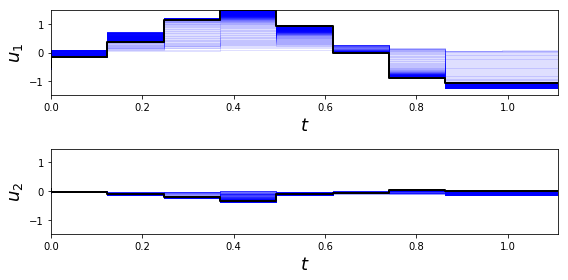

In [18]:
plot_grape_control_fields(times, result.u / (2 * np.pi), H_labels, uniform_axes=True);

We can now evaluate the overlap of the obtained sequence with the desired unitary :

In [38]:
abs(_overlap(U, result.U_f))**2

0.9999999867707563

The amplitude controls $u_1$ and $u_2$ are functions of the power and the phase. We can retrieve the latter with :
\begin{align}
&\Omega(t) = \sqrt{u_1(t)^2 + u_2(t)^2} \\
&\phi(t) = \textrm{atan}(\frac{u_2(t)}{u_1(t)})
\end{align}

In [19]:
def getControl(u1, u2) :
    # For a given list of controls u1 and u2, retrieve the corresponding power and phase
    
    
    om = [None] * len(u1)
    phi = [None] * len(u1)
    
    for i in range(len(u1)) :
        om[i] = sqrt(u1[i]**2 + sqrt(u2[i]**2))
        phi[i] = atan2(u2[i], u1[i])
        
    return [om, phi]

In [20]:
# Retrieve the final optimized set of controls
u1_f = result.u[R-1][0]
u2_f = result.u[R-1][1]

[omegas, phis] = getControl(u1_f, u2_f)

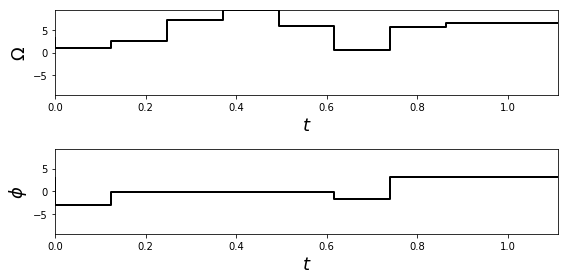

In [25]:
plot_grape_control_fields(times, np.asarray([[omegas, phis]]), [r'$\Omega$', r'$\phi$'], uniform_axes=True);

## 3. Robustness

Given a pulse sequence from a set of controls $u_k(t)$, we wish to find its robustness, particularly to detuning errors. 

In [39]:
def compute_unitary(u, delta) :
    # Computes the unitary operator for a given detuning error delta
    
    dt = times[1] - times[0] 
        
    J = len(u)
    M = len(times)
    
    def H_err(delta) :
        # Hamiltonian for a detuning error
        return delta * (sigmaz_22 + sigmaz_33)
    
    def _H_idx(idx):
        # Total Hamiltonian at a given time step
        return H0 + H_err(delta) + sum([u[j][idx] * H_ops[j] for j in range(J)])
    
    U_list = [(-1j * _H_idx(idx) * dt).expm() for idx in range(M-1)]
        
    U_f = 1
    for m in range(M - 1):
        U_f = U_list[m] * U_f
    
    return U_f

def detuning_fidelity(u, delta, type = "") :
    
    U_f = compute_unitary(u, delta)
    
    Bket = (1/sqrt(2))*(basis(3,1) + basis(3,2))
    s0pket = basis(3,0) 
    
    if type == "U" :
        return abs(_overlap(U, U_f))**2
    elif type == "B_0" :
        # Calculate <0| Uf |B>
        return fidelity(s0pket, (U_f * Bket))
    elif type == "0_B" :
        # Calculate <B| Uf |0>
        return fidelity(Bket, (U_f * s0pket))
    else :
        return 0

In [40]:
det_fracs =  np.linspace(- 0.5, 0.5, 51) # Fractional detuning list
fids_U   = np.log10(1-np.asarray([detuning_fidelity([u1_f,u2_f], Delta * det_fracs_i, "U") for det_fracs_i in det_fracs]))
fids_B_0 = np.log10(1-np.asarray([detuning_fidelity([u1_f,u2_f], Delta * det_fracs_i, "B_0") for det_fracs_i in det_fracs]))
fids_0_B = np.log10(1-np.asarray([detuning_fidelity([u1_f,u2_f], Delta * det_fracs_i, "0_B") for det_fracs_i in det_fracs]))

In [41]:
fids_U

array([-1.40609543, -1.44100896, -1.47745614, -1.51557138, -1.55550788,
       -1.59744128, -1.64157428, -1.68814251, -1.73742203, -1.78973921,
       -1.84548368, -1.90512591, -1.96924112, -2.03854299, -2.113932  ,
       -2.19656684, -2.28797369, -2.39022029, -2.50620683, -2.64018314,
       -2.79874269, -2.99294257, -3.24354249, -3.59726968, -4.20409778,
       -7.87946375, -4.18496181, -3.58771547, -3.23718863, -2.98819361,
       -2.79496042, -2.63704844, -2.50353735, -2.38790206, -2.28593072,
       -2.19474591, -2.11229444, -2.03705976, -1.96788987, -1.9038891 ,
       -1.84434726, -1.78869174, -1.73645411, -1.68724629, -1.64074314,
       -1.59666958, -1.55479079, -1.51490472, -1.47683626, -1.44043268,
       -1.40555992])

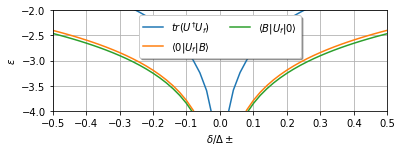

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(det_fracs, fids_U, label =r'$tr(U^\dag U_f)$')
ax.plot(det_fracs, fids_B_0, label = r'$\langle 0 | U_f| B \rangle $')
ax.plot(det_fracs, fids_0_B, label = r'$\langle B | U_f| 0 \rangle $')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
plt.ylim((-4, -2))
plt.xlim((-0.5, 0.5))
ax.set_aspect(aspect=0.15)
plt.grid()
plt.xticks([-0.5,-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.xlabel(r'$\delta/\Delta\pm$')
plt.ylabel(r'$\epsilon$')
plt.show()